###### This challenge is intellectual property of SAP. Do not share.
# SAP Machine Learning Challenge 

> Applicant: Thanaphon "Bom" Chavengsaksongkram

> Email: S1778742@ed.ac.uk



# Task 

## Which Novel Do I Belong To? 

In this challenge, you are tasked with training a machine learning model that classiﬁes a given line of text as belonging to one of the following 12 novels: 

0: alice_in_wonderland 1: dracula 2: dubliners 3: great_expectations 4: hard_times 5: huckleberry_ﬁnn 6: les_miserable 7: moby_dick 8: oliver_twist 9: peter_pan 10: tale_of_two_cities 11: tom_sawyer 


You are provided with a zip ﬁle (oﬄine_challenge.zip) containing three text ﬁles:

Example:

> line: satwamuluhqgulamlrmvezuhqvkrpmletwulcitwskuhlemvtwamuluhiwiwenuhlrvimvqvkruh ulenamuluhqgqvtwvimviwuhtwamuluhulqvkrenamcitwuhvipmpmqvuhskiwkrpmdfuhlrvimv skvikrpmqvuhskmvgzenleuhqvmvamuluhulenamuluhqvletwtwvipmpmgzleenamuhtwamuluh twletwdfuhiwkrxeleentwxeuhpmqvuhtwiwmvamdfuhpkeztwamuluhvimvuhqvtwmkpmpmlelr uhgztwtwskuhtwlrkrpmlruhpmuluhqvenuhtwyplepmxeuhenuhamypkrqvuhamulmvdfuhqvsk entwamletwlrlrpmiwuhtwamul 

> label: 7 

## Your Task 
 
You are tasked with developing a machine learning model (deep learning preferred) that predicts the novel id of a given line of text.

# Table of Content

## A. Exploration of Dataset
#### 1. Classes Distribution


## B. Understanding Dataset
#### 1. Treating each character as a word
#### 2. Simple language model (N-gram / TF-IDF)
#### 3. Least Common Sequence
#### 4. Other methods

## C. Classical Machine Learning Approach (SVM)
#### 1. Build feature vector
#### 2. Standardization / Noise filter
#### 3. PCA
#### 4. Building Classifier & Evaluate

## D. Deep Learning
#### 1. Selecting Feature
#### 2. Simple LSTM
#### 3. Simple CNN
#### 4. Deep CNN

## E. Classify Test Set
#### 1. CNN classification
#### 2. SVM classification

## Imports

Include all required imports and execute the cell below.

In [1]:
from __future__ import print_function, division
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer

os.environ['KERAS_BACKEND'] = 'tensorflow'
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.utils import to_categorical
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.core import Dense, Activation
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM
from keras.layers import Flatten, BatchNormalization, Dense, Dropout, Embedding, Conv1D, GlobalAveragePooling1D, MaxPooling1D
from keras.callbacks import ModelCheckpoint

%matplotlib inline

Using TensorFlow backend.


# Environment Settings

Setting environment parameters for this experiment.

In [2]:
#Training datafiles
train_file = "xtrain_obfuscated.txt"
train_target_file = "ytrain.txt"
test_file = "xtest_obfuscated.txt"

seed = 180228

num_class = 12

#Deep Learning Settings
max_embedding_length = 500
max_embedding_features = 20000
best_weight_file_name = "best_weight.hdf5"

## A. Exploration of the dataset

Our goal is classify documents into 12 different classes. Each document is a series of string with associated label.  

In [3]:
# Load the raw datasets
with open(train_file) as f:
    raw_train_data = f.read().splitlines() 

with open(train_target_file) as f:
    raw_train_target = f.read().splitlines() 

with open(test_file) as f:
    raw_test_data = f.read().splitlines() 

# Description of the dataset
print("There are {} training data, {} training target, {} test data.".format(len(raw_train_data), len(raw_train_target), 
      len(raw_test_data)))

There are 32513 training data, 32513 training target, 3000 test data.


### 1. Classes Distribution

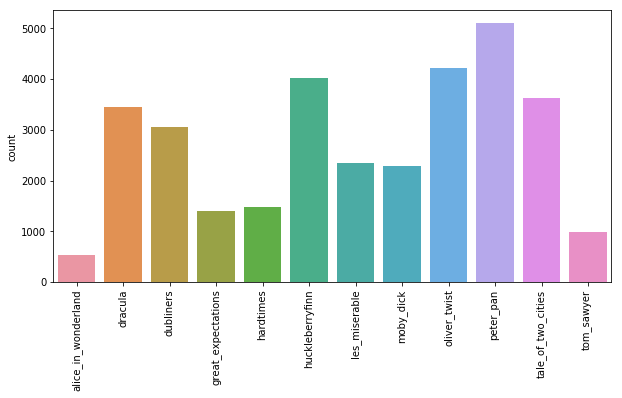

In [11]:
author_label = ["alice_in_wonderland",
"dracula",
"dubliners",
"great_expectations",
"hardtimes",
"huckleberryﬁnn",
"les_miserable",
"moby_dick",
"oliver_twist",
"peter_pan",
"tale_of_two_cities",
"tom_sawyer"]

figure = plt.figure(figsize=(10,5))
ax = sns.countplot(x = raw_train_target)
ax.set_xticklabels(author_label,rotation=90)
plt.show()

# B. Understanding the dataset

Each document composes of a string sequence without any spaces.

### 1. Treating each character as a word

Potentially, each character could represent a word. To test this hypothesis, I am going to bag each character into a histogram and see how well it performs on naive Bayes classifier. If each character represents a word, then independent assumption of naive Bayes should lead to reasonable classification performance. 


In [6]:
run_this = 0
if run_this == 1:
    letters = list(map(chr, range(ord('a'), ord('z')+1)))
    X = []
    for line in raw_train_data:
        row = []
        for c in letters:
            row.append(line.count(c))
        X.append(row)
    Y = np.array(raw_train_target)
    X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.20, random_state=seed)
    gnb = GaussianNB()
    gnb.fit(X_train,y_train)
    y_pred = gnb.predict(X_val)
    val_acc = accuracy_score(y_val, y_pred, normalize=True)
    print("NB Validation Accuracy: {}".format(val_acc))

NB Validation Accuracy: 0.3186221743810549


#### Findings

Poor classification performance indicates that this hypothesis is incorrect. Each character must have some sort of relationship to one another. 



### 2. Simple language model (N-gram / TF-IDF)

The feature could be encoded to N-gram then convert to Term Frequence Inverse Document Feature (tf-idf). If this sequence of string represents
a word of N size, then we would likely see improvement even with Naive Bayes classifier.

#### Selecting N-gram models.

Run 1-5 N-gram model and see which one leads to the highest validation accuracy. However, big N value will lead to a very sparse feature matrix.


In [4]:
run_this = 0

if run_this == 1:
    # Convert target label to numpy array
    Y = np.array(raw_train_target)
    
    # Evaluate 1-6 gram language model
    for i in range(1,6):
        # Build tf-idf feature extracter
        featureExtractor = TfidfVectorizer(ngram_range=(1,i),analyzer='char')
        X = featureExtractor.fit_transform(raw_train_data)
        # Split training / validation set.
        X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.20, random_state=seed)
        # Evaluate N-gram model using Gaussian Naive Bayes classifier
        gnb = GaussianNB()
        gnb.fit(X_train.toarray(),y_train)
        y_pred = gnb.predict(X_val.toarray())
        val_acc = accuracy_score(y_val, y_pred, normalize=True)
        print("{}-gram. NB Validation Accuracy: {}".format(i,val_acc))

1-gram. NB Validation Accuracy: 0.3189297247424266
2-gram. NB Validation Accuracy: 0.22651084115023834
3-gram. NB Validation Accuracy: 0.2992465016146394
4-gram. NB Validation Accuracy: 0.46178686759956944
5-gram. NB Validation Accuracy: 0.5492849454098109


#### Findings

1 to 5-gram appears to have the most promising result. A more powerful classifier such as Support Vector Machine (SVM) could be used against this feature set to improve accuracy.

### 3. Least Common Sequence

Every author could share something similar in each of their work. I wonder if there would be any common sequence appearing for each string. Although a bit rudimentary, running least common sequence algorithm across all string for each label could potentially give us more information about this dataset.


In [28]:
def leastCommonSequence(s1, s2):
    """
    Return least common shared sequence of character between two strings
    """
    matrix = [["" for x in range(len(s2))] for x in range(len(s1))]
    for i in range(len(s1)):
        for j in range(len(s2)):
            if s1[i] == s2[j]:
                if i == 0 or j == 0:
                    matrix[i][j] = s1[i]
                else:
                    matrix[i][j] = matrix[i-1][j-1] + s1[i]
            else:
                matrix[i][j] = max(matrix[i-1][j], matrix[i][j-1], key=len)
    cs = matrix[-1][-1]
    return cs


In [29]:
run_this = 0

if run_this == 1:
    X = np.array(raw_train_data)
    Y = np.array(raw_train_target)
    for c in [str(j) for j in range(num_class)]:
        index = np.argwhere(Y == c)
        str1 = X[1]
        for i in index:
            str1 = leastCommonSequence(str1,X[i][0])
        print("class: ",c," Length: ",len(str1))
        print(str1)

class:  0  Length:  45
muvuhuhuhuhumuhtwmuhmmuvuhuhuhuhvuhuhtwuhuuuh
class:  1  Length:  44
uuhuhvuhumuhuhvuhuhuhuhuuhuhtwuheumuhuhmuhuh
class:  2  Length:  36
twuhtwluhuhuhuhuhtwuhuhuhuuuhuhuuuuh
class:  3  Length:  38
uhuhtuhuluuhuuhuhwuhuuhluhuhuhuhuuuhuh
class:  4  Length:  35
uhmuhtwuluuuhuhuhuvuhmuhmuhuhuhuhuu
class:  5  Length:  33
uhuhumuheuhvuhwuuhmuuhuhuhuuhuhuh
class:  6  Length:  32
luuuhuhuhuuuuuhuhuuhuhuuhuhuuuhw
class:  7  Length:  39
uhmuhuuhuhuhuhuuhmuhmuhuuhuluhwuhuhuvuh
class:  8  Length:  37
uhuhuhuhuluhvuhuhuuhwuhhuhvuhuhuheuhu
class:  9  Length:  40
muhuhtweuuhuuhvuhuhtwumuhmmuhuuhuhuuhuuh
class:  10  Length:  37
muhuhuluuhuhmuhuhwuhuluhuhmuuhuuhuhmu
class:  11  Length:  42
vuhmuuhuhvuhuhuhmvuhvuhmuhuhuuhmuhuhuhuhuh


#### Findings

Interestingly, there is a sizable common sequence occurring for each author, especially there are over 32,000 documents in this training set. 


I hypothesize that the creator of this challenge generates a common sequence for each author then padded the data with random characters. If this is the case, then we can treat it like an image classification problem. We would expect poor performance from Recurrent Neural Network and perhaps better performance with Convolutional Neural Network.



### 4. Other consideration

##### FastText, Word2Vec, Doc2Vec, GoLve features

State of the art feature extractor are likely infeasible use on this challenge since they were pre-trained on a large language dataset like English. This is not quite applicable to our dataset here. 

# C. Classical Machine Learning Approach

#### Support Vector Machine

In this section, linear Support vector machine trained on 1 to 5-gram td-idf features are built. Performance is then measured.


### 1. Build feature vectors


In [4]:
run_classical_ML = 0  #Set to 0, if do not want to run this section

In [13]:
if run_classical_ML == 1:
    N_gram = 5
    featureExtractor = TfidfVectorizer(ngram_range=(1,N_gram),analyzer='char')
    X = featureExtractor.fit_transform(raw_train_data)
    X_tr = X.toarray()
    Y = np.array(raw_train_target)
    Y = Y.astype(int)

### 2. Standardization / Filtering out Noises
It's a good practice that Training Data is standardized to zero mean and unit variance for linear models. This is not possible due to dataset being too large. Perhaps batch processing is required, but I will skip for now. To do later if time permitted.

In [6]:
# Dataset too big to run on this PC. Todo: batch process later? Get rid of noises using three-sigma rule?
run_this = 0

if run_classical_ML == 1 and run_this == 0:
    stdScaler = StandardScaler()
    stdScaler.fit(X.toarray())
    X_tr = stdScaler.transform(X)

### 3. Reduce dimension of Sparse Dataset with Principal Component Analysis
Our N-gram model is quite large and sparse. We can probably reduce its dimension using PCA. Though there's not enough memory to fit the entire dataset on my laptop. To do later if time permitted.

In [ ]:
# Dataset too big to run on this PC. Todo: batch process later?
run_this = 0

if run_classical_ML == 1 and run_this == 0:
    X_tr = np.array(X_tr)
    pca = PCA(n_components = len(X_tr.columns),random_state = seed)
    pca.fit(X_tr)
    pca_ratio = pca.explained_variance_ratio_

    # Plot the PCA ratio spectrum
    plt.figure(1, figsize = (10, 9))
    plt.clf()
    plt.axes([.2, .2, .7, .7])
    plt.plot(np.arange(1, len(pca_ratio) + 1),pca_ratio, linewidth = 2)
    plt.axis('tight')
    plt.xlabel('number of components (n)')
    plt.ylabel('explained variance ratio')

    ###Finding number of components that explain 95% of variance
    area = 0
    index = 0
    for count ,ratio in enumerate(pca.explained_variance_ratio_):
        area = area + ratio
        if (area >= 0.95):
            index = count + 1
            break
        
    ax = plt.vlines(index, min(pca.explained_variance_ratio_), max(pca.explained_variance_ratio_), linestyles = "dotted")
    ax = ax.axes 
    text = " {} eigen vectors used to explained 95% of variance".format(index)
    ax.annotate(text,
                xy = (index, 0.0),
                xytext=(index, 0.1), xycoords = 'data')
    plt.grid(True)
    plt.show()

### 4. Build and evaluate model

Using hold-out validation set. There is not computing resource to perform the ideal cross-validation over this large sparse dataset. Hyper-parameters cannot be optimized at the moment due to resource limitation.

In [14]:
if run_classical_ML == 1:
    # Although Cross-validation is preferred, it's very expensive for large dataset. Holdout is used to evaluate model instead.
    X_train, X_val, y_train, y_val = train_test_split(X_tr, Y, test_size=0.20, random_state=seed)
    #Use liblinear for speed
    svm = LinearSVC()  
    svm.fit(X_train, y_train)
    y_pred = svm.predict(X_val)
    val_acc = accuracy_score(y_val, y_pred, normalize=True)
    print("val acc: {}".format(val_acc))

val acc: 0.8576041826849147


In [15]:
def plotConfusionMatrix(cm, classes=None, title='Confusion matrix'):
    """Plots a confusion matrix."""
    plot = plt.figure(figsize=(10,10))
    if classes is not None:
        sns.heatmap(cm, xticklabels=classes, yticklabels=classes, vmin=0., vmax=1., annot=True)
    else:
        sns.heatmap(cm, vmin=0., vmax=1.)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    return plot

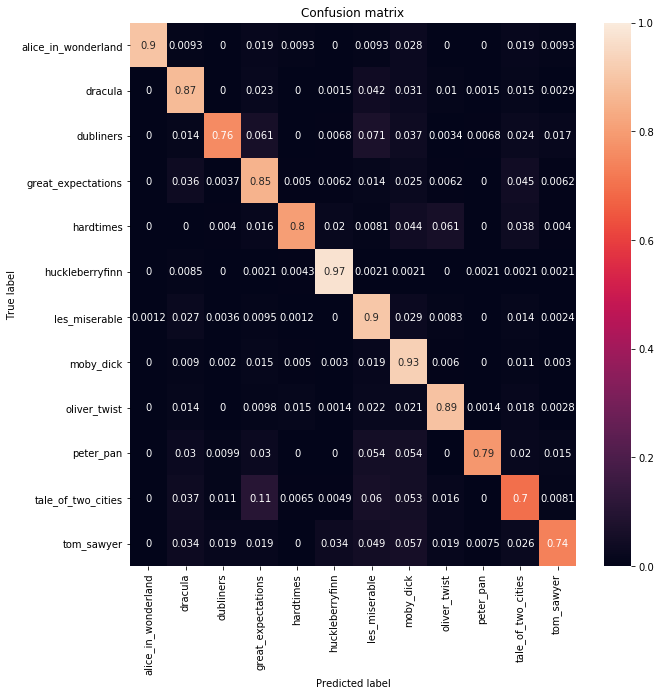

In [16]:
run_this = 0

if run_this == 1 and run_classical_ML == 1:
    cm = confusion_matrix(y_val, y_pred)
    cm_norm = cm/cm.sum(axis=1)[:, np.newaxis]
    plot = plotConfusionMatrix(cm_norm, classes=author_label)

#### Findings

Linear Support Vector Machine trains very fast and perofrm extremely well on validation set 1-5 Gram. Hyper-parameters could be improved if resource permitted.

# C. Deep Learning Approach

### Approach

Long short-term memory network is a kind of recurrent neural network that is good at learning dependencies between two points in a sequence that are separated very far in time. Since we're classifying a document, some of the words in the document may contain contextual information that helps identify the author. LSTM is often used in many language tasks such as sentiment analysis.

However, based on the finding of section B.3, the hypothesis is that each document is generated by the random padding of least common string sequence. This means that each word or characters carry no contextual information. The author is likely be defined based on style/structure of the document. As a result, the prediction is that LSTM will perform poorly while CNN will shine.

As an experiment, a small LSTM and a CNN network are built to test this theory.


### 1.  Building feature sequences

In [ ]:
run_deepLearning_ML = 1  # Change to zero to not run this part

In [4]:
if run_deepLearning_ML == 1:
    tokenizer = Tokenizer(lower=True, split=" ", char_level=True)
    tokenizer.fit_on_texts(raw_train_data)
    X = []
    for line in raw_train_data:
        row = []
        for item in tokenizer.texts_to_sequences(line):
            row.append(int(item[0]))
        X.append(row)
    X = sequence.pad_sequences(X, maxlen=max_embedding_length)
    Y = np.array(raw_train_target).astype(int)
    Y = to_categorical(Y, num_class)

In [5]:
def simpleLSTM():
    model = Sequential()
    model.add(Embedding(max_embedding_features, 128, input_length=max_embedding_length))
    model.add(Dropout(0.2))
    model.add(LSTM(128))
    model.add(Dense(num_class,activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def simpleCNN():
    model = Sequential()
    model.add(Embedding(max_embedding_features, 256, input_length=max_embedding_length))
    model.add(Dropout(0.2))
    model.add(Conv1D(64, 3))
    model.add(LeakyReLU(alpha=0.01)) 
    model.add(MaxPooling1D(2))
    model.add(Flatten())
    model.add(Dense(num_class,activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# D. Final classification
def plotTrainingGraph(data):
    history = data.history
    plt.style.use('ggplot')
    accuracy_plot = plt.figure(figsize=(10,5))
    for k in ['val_acc', 'acc']:
        data = np.array(history[k])
        plt.plot(data)
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch Number')
    plt.legend(['acc(valid)', 'acc(train)'], loc='upper left')
    plt.grid(True)
    plt.show()
    loss_plot = plt.figure(figsize=(10,5))
    for k in ['loss', 'val_loss']:
        data = np.array(history[k])
        plt.plot(data)
    plt.title('Model Loss')
    plt.ylabel('Error (Log Loss)')
    plt.xlabel('Epoch Number')
    plt.grid(True)
    plt.legend(['error(train)', 'error(valid)'], loc='upper left')
    plt.show()
    #Save visualization data
    print("Max Val Acc: ",np.max(np.array(history['val_acc'])))
    print("Max Train Acc: ", np.max(np.array(history['acc'])))


### 2. Simple LSTM

Train on 29261 samples, validate on 3252 samples
Epoch 1/10
29261/29261 [==============================] - 91s 3ms/step - loss: 2.3608 - acc: 0.1628 - val_loss: 2.3223 - val_acc: 0.1814
Epoch 2/10
29261/29261 [==============================] - 88s 3ms/step - loss: 2.2825 - acc: 0.1910 - val_loss: 2.2597 - val_acc: 0.2002
Epoch 3/10
29261/29261 [==============================] - 89s 3ms/step - loss: 2.2394 - acc: 0.2026 - val_loss: 2.2257 - val_acc: 0.2082
Epoch 4/10
29261/29261 [==============================] - 89s 3ms/step - loss: 2.2319 - acc: 0.2056 - val_loss: 2.2352 - val_acc: 0.2017
Epoch 5/10
29261/29261 [==============================] - 88s 3ms/step - loss: 2.2117 - acc: 0.2076 - val_loss: 2.2130 - val_acc: 0.2094
Epoch 6/10
29261/29261 [==============================] - 88s 3ms/step - loss: 2.2017 - acc: 0.2104 - val_loss: 2.2027 - val_acc: 0.2177
Epoch 7/10
29261/29261 [==============================] - 88s 3ms/step - loss: 2.1942 - acc: 0.2126 - val_loss: 2.1612 - val_acc:

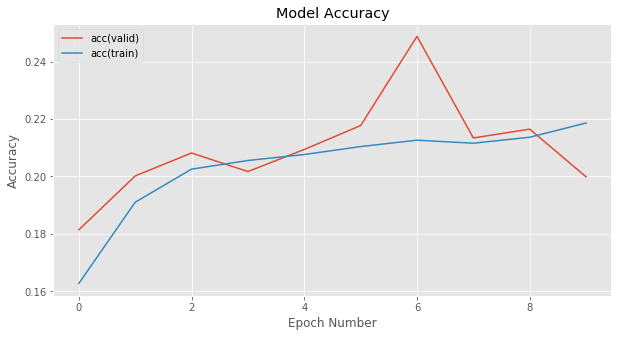

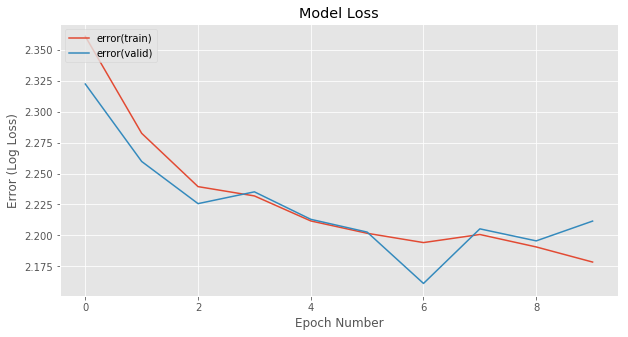

Max Val Acc:  0.248769987223
Max Train Acc:  0.218618639199


In [11]:
run_this = 0

if run_this == 1 and run_deepLearning_ML == 1:
    model = simpleLSTM()
    train_history = model.fit(X, Y, batch_size=500, epochs=10, verbose=1, validation_split=0.1, shuffle=True)
    plotTrainingGraph(train_history)

### 3.  Simple CNN

Train on 29261 samples, validate on 3252 samples
Epoch 1/10
29261/29261 [==============================] - 15s 512us/step - loss: 2.3126 - acc: 0.1731 - val_loss: 2.2353 - val_acc: 0.2359
Epoch 2/10
29261/29261 [==============================] - 13s 432us/step - loss: 2.0344 - acc: 0.2992 - val_loss: 2.0193 - val_acc: 0.2983
Epoch 3/10
29261/29261 [==============================] - 13s 432us/step - loss: 1.7546 - acc: 0.3991 - val_loss: 1.9490 - val_acc: 0.3266
Epoch 4/10
29261/29261 [==============================] - 13s 432us/step - loss: 1.5290 - acc: 0.4820 - val_loss: 1.9323 - val_acc: 0.3355
Epoch 5/10
29261/29261 [==============================] - 13s 432us/step - loss: 1.3261 - acc: 0.5548 - val_loss: 1.9443 - val_acc: 0.3506
Epoch 6/10
29261/29261 [==============================] - 13s 432us/step - loss: 1.1605 - acc: 0.6149 - val_loss: 2.0131 - val_acc: 0.3472
Epoch 7/10
29261/29261 [==============================] - 13s 432us/step - loss: 1.0217 - acc: 0.6593 - val_loss: 2.0

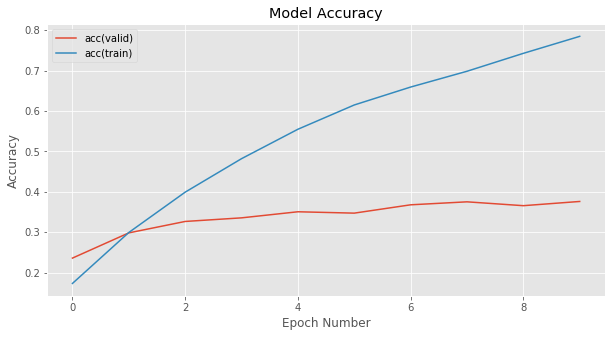

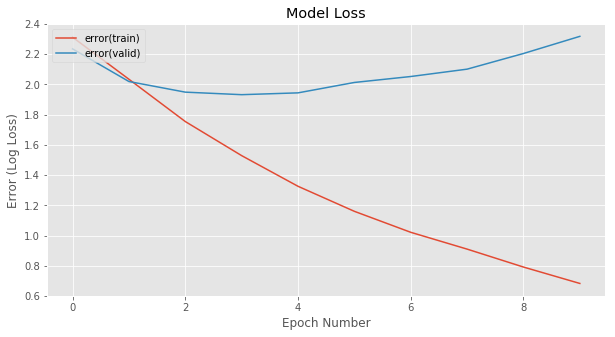

Max Val Acc:  0.376076256914
Max Train Acc:  0.784833051433


In [10]:
run_this = 0

if run_this == 1 and run_deepLearning_ML == 1:
    model = simpleCNN()
    train_history = model.fit(X, Y, batch_size=500, epochs=10, verbose=1, validation_split=0.1, shuffle=True)
    plotTrainingGraph(train_history)

#### Findings

Unsurprisingly, CNN outperforms LSTM. This somewhat support the original hypothesis. Next step is to train a relatively a deep CNN to increase representation power and accuracy.

### 4. Deep CNN Model

The choice of leaky relu activation function is to prevent diminishing gradient and dead units.  Dropout
are used as a regularization technique. Since weights are not initialized in a particular way, Batchnormalization is used.
AveragePooling before fully connected layer is used instead of MaxPooling before fully connected layer. This appears to work better as fully connected layer can benefited from all information from the convolutional layer. Adam learning rule is used with default setting. This paper shows that Adam Learning rule works well in most cases https://arxiv.org/pdf/1412.6980.pdf.

Since each document contains around 500 characters, convolutional kernel size is limited to 128.

Validation set is 10% of the training set.

**Acknowledgement:** This deep CNN model is loosely based on this paper: https://arxiv.org/abs/1509.01626 .

In [6]:
def deepCNN():
    model = Sequential()
    model.add(Embedding(max_embedding_features, 256, input_length=max_embedding_length))
    model.add(Dropout(0.2))
    model.add(Conv1D(64, 3))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01)) 
    model.add(Conv1D(64, 3))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01)) 
    model.add(MaxPooling1D(2))
    model.add(Dropout(0.25))
    model.add(Conv1D(128, 3))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01)) 
    model.add(Conv1D(128, 3))
    model.add(GlobalAveragePooling1D())
    model.add(Dropout(0.5))
    model.add(Dense(512))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01)) 
    model.add(Dense(256))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01)) 
    model.add(Dense(num_class,activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


Train on 29261 samples, validate on 3252 samples
Epoch 1/100
29261/29261 [==============================] - 33s 1ms/step - loss: 2.1691 - acc: 0.2534 - val_loss: 2.4321 - val_acc: 0.1624
Epoch 2/100
29261/29261 [==============================] - 30s 1ms/step - loss: 1.5208 - acc: 0.4758 - val_loss: 1.8399 - val_acc: 0.4034
Epoch 3/100
29261/29261 [==============================] - 30s 1ms/step - loss: 1.2733 - acc: 0.5553 - val_loss: 2.3135 - val_acc: 0.3792
Epoch 4/100
29261/29261 [==============================] - 30s 1ms/step - loss: 1.1640 - acc: 0.5902 - val_loss: 1.1402 - val_acc: 0.6030
Epoch 5/100
29261/29261 [==============================] - 30s 1ms/step - loss: 1.0969 - acc: 0.6159 - val_loss: 1.1357 - val_acc: 0.6089
Epoch 6/100
29261/29261 [==============================] - 30s 1ms/step - loss: 1.0536 - acc: 0.6317 - val_loss: 1.0621 - val_acc: 0.6316
Epoch 7/100
29261/29261 [==============================] - 30s 1ms/step - loss: 1.0109 - acc: 0.6484 - val_loss: 1.0859 - v

Epoch 29/100
29261/29261 [==============================] - 29s 1ms/step - loss: 0.5877 - acc: 0.7990 - val_loss: 0.6882 - val_acc: 0.7595
Epoch 30/100
29261/29261 [==============================] - 30s 1ms/step - loss: 0.5825 - acc: 0.7987 - val_loss: 0.6394 - val_acc: 0.7854
Epoch 31/100
29261/29261 [==============================] - 30s 1ms/step - loss: 0.5714 - acc: 0.8029 - val_loss: 0.6186 - val_acc: 0.7980
Epoch 32/100
29261/29261 [==============================] - 30s 1ms/step - loss: 0.5650 - acc: 0.8075 - val_loss: 0.5926 - val_acc: 0.8035
Epoch 33/100
29261/29261 [==============================] - 29s 1ms/step - loss: 0.5593 - acc: 0.8066 - val_loss: 0.6585 - val_acc: 0.7847
Epoch 34/100
29261/29261 [==============================] - 30s 1ms/step - loss: 0.5491 - acc: 0.8102 - val_loss: 0.5697 - val_acc: 0.8146
Epoch 35/100
29261/29261 [==============================] - 29s 1ms/step - loss: 0.5403 - acc: 0.8160 - val_loss: 0.6030 - val_acc: 0.8007
Epoch 36/100
29261/29261 [=

Epoch 59/100
29261/29261 [==============================] - 29s 1ms/step - loss: 0.4255 - acc: 0.8514 - val_loss: 0.5226 - val_acc: 0.8358
Epoch 60/100
29261/29261 [==============================] - 30s 1ms/step - loss: 0.4209 - acc: 0.8546 - val_loss: 0.4792 - val_acc: 0.8426
Epoch 61/100
29261/29261 [==============================] - 29s 1ms/step - loss: 0.4220 - acc: 0.8548 - val_loss: 0.4957 - val_acc: 0.8386
Epoch 62/100
29261/29261 [==============================] - 30s 1ms/step - loss: 0.4141 - acc: 0.8567 - val_loss: 0.5476 - val_acc: 0.8241
Epoch 63/100
29261/29261 [==============================] - 29s 1ms/step - loss: 0.4122 - acc: 0.8585 - val_loss: 0.5312 - val_acc: 0.8284
Epoch 64/100
29261/29261 [==============================] - 30s 1ms/step - loss: 0.4142 - acc: 0.8559 - val_loss: 0.5230 - val_acc: 0.8315
Epoch 65/100
29261/29261 [==============================] - 29s 1ms/step - loss: 0.3996 - acc: 0.8609 - val_loss: 0.5150 - val_acc: 0.8333
Epoch 66/100
29261/29261 [=

Epoch 90/100
29261/29261 [==============================] - 30s 1ms/step - loss: 0.3549 - acc: 0.8749 - val_loss: 0.4811 - val_acc: 0.8469
Epoch 91/100
29261/29261 [==============================] - 30s 1ms/step - loss: 0.3526 - acc: 0.8761 - val_loss: 0.4952 - val_acc: 0.8416
Epoch 92/100
29261/29261 [==============================] - 29s 1ms/step - loss: 0.3496 - acc: 0.8782 - val_loss: 0.4969 - val_acc: 0.8370
Epoch 93/100
29261/29261 [==============================] - 29s 1ms/step - loss: 0.3508 - acc: 0.8803 - val_loss: 0.4878 - val_acc: 0.8484
Epoch 94/100
29261/29261 [==============================] - 30s 1ms/step - loss: 0.3477 - acc: 0.8774 - val_loss: 0.4898 - val_acc: 0.8392
Epoch 95/100
29261/29261 [==============================] - 29s 1ms/step - loss: 0.3426 - acc: 0.8795 - val_loss: 0.4697 - val_acc: 0.8506
Epoch 96/100
29261/29261 [==============================] - 29s 1ms/step - loss: 0.3478 - acc: 0.8778 - val_loss: 0.4827 - val_acc: 0.8438
Epoch 97/100
29261/29261 [=

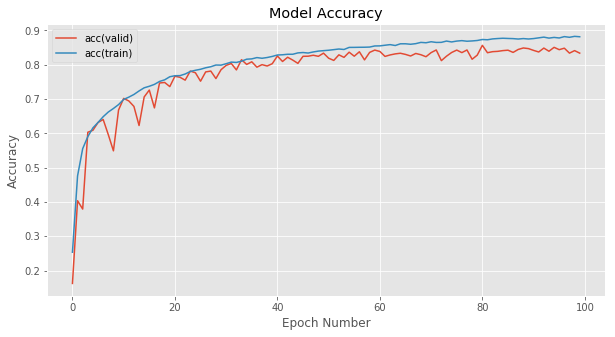

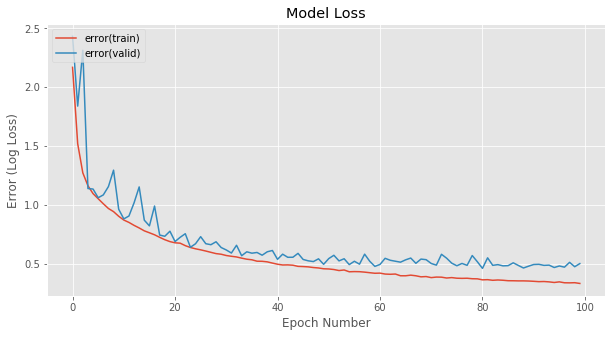

Max Val Acc:  0.856396064181
Max Train Acc:  0.882574076292


In [7]:
run_this = 1

if run_this == 1 and run_deepLearning_ML == 1:
    #Save the weight with the best validation accuracy, then reload later as the final model
    checkpoint = ModelCheckpoint(best_weight_file_name, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [checkpoint]
    model = deepCNN()
    train_history = model.fit(X, Y, batch_size=100, epochs=100, verbose=1, validation_split=0.1, shuffle=True,callbacks=callbacks_list )
    plotTrainingGraph(train_history)

32513/32513 [==============================] - 10s 302us/step


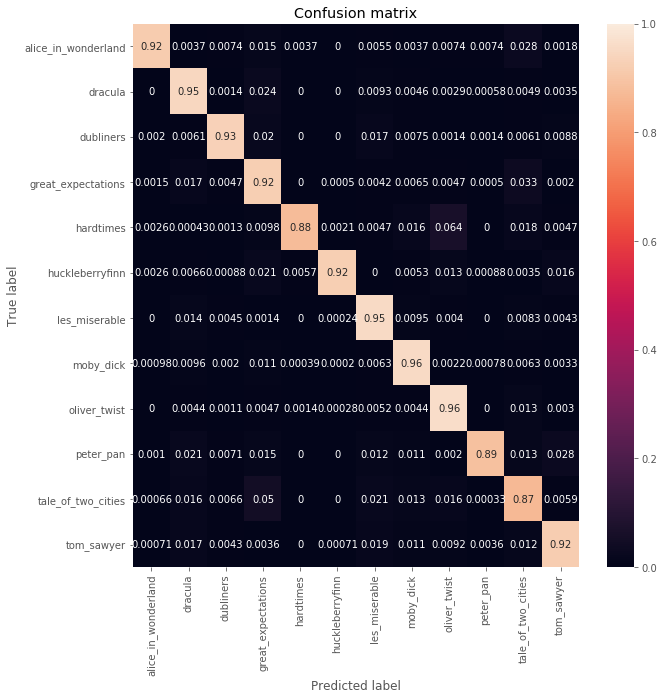

In [15]:
# Plotting confusion Matrix on training set
run_this = 1

if run_this == 1 and run_deepLearning_ML == 1:
    model = deepCNN()
    model.load_weights(best_weight_file_name)
    Y = np.array(raw_train_target).astype(int)
    Y_pred = model.predict_classes(X)
    cm = confusion_matrix(Y, Y_pred)
    cm_norm = cm/cm.sum(axis=1)[:, np.newaxis]
    plot = plotConfusionMatrix(cm_norm, classes=author_label)
    

#### Findings

Our deep CNN model performs quite well with around 85% validation accuracy. Based on training graph, the model doesn't appear to be overfitting. Reclassifying the training dataset set confirming relatively high performance of this model.

This model will be used to classify the test set.

# D. Classifying Test Set

Load and classify test set

In [19]:
# Re-initialize the model and reload the weight.
run_this = 1

if run_this == 1:
    model = deepCNN()
    model.load_weights(best_weight_file_name)

    X_test = []
    for line in raw_test_data:
        row = []
        for item in tokenizer.texts_to_sequences(line):
            row.append(int(item[0]))
        X_test.append(row)
    X_test = sequence.pad_sequences(X_test, maxlen=max_embedding_length)
    Y_test = model.predict_classes(X_test)
    print(Y_test.shape)

    with open('ytest_CNN.txt', 'w') as outfile:
        for item in Y_test:
            outfile.write("{}\n".format(item))

3000/3000 [==============================] - 1s 365us/step
(3000,)


# SVM version

In [17]:
# SVM must be trained first on section C
run_this = 0

if run_this == 1:
    X_test = featureExtractor.transform(raw_test_data)
    X_test = X_test.toarray()
    
    Y_test = svm.predict(X_test)

    with open('ytest_SVM.txt', 'w') as outfile:
        for item in Y_test:
            outfile.write("{}\n".format(item))

# E. Summary

Final results are generated by CNN model, despite SVM having similar accuracy.

## Conclusion
This model presented the first approximation to novel classification challenge. The main outcome is the following:

1. Several models are built with comparable performance.

2. Each character of the sequence does not represent a word. This makes identifying individual words a challenge. N-gram models are proposed and see a significant improvement.

3. State-of-the-art text feature representations are not used since these do not represent actual language and trained model will likely not work well.

4. The least common sequence is used and found that these documents are likely generated from common sequence per author and padded with random characters. This theory is further strengthened by poor performance from contextual learning models such as LSTM and high performance of structural learning model such as CNN.

5. The initial models presents are SVM and Deep CNN model with both validation accuracy of around 85%. 

## Future work

1. Perform grid-search for best hyper-parameters.
2. Random factors should be minimized such as weight initialization.
3. Standardize and reduce the dimensionality of data could improve SVM results.
4. There may be a better representation of the training data than tf-idf or character sequences.
5. Noises in the dataset could be filtered out using three-sigma rule, etc.
6. The accuracy of a DeepCNN could potentially be boosted by deriving features learned from the network. This can be done by capturing the activations of the last fully connected layer, then feed them into a more powerful classifier such as GradientBoost or SVM classifier.

